In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/cansat2024/submission/Dataset/
%cp -av v1 /content/dataset

/content/drive/MyDrive/cansat2024/submission/Dataset
'v1' -> '/content/dataset'
'v1/README.roboflow.txt' -> '/content/dataset/README.roboflow.txt'
'v1/README.dataset.txt' -> '/content/dataset/README.dataset.txt'
'v1/valid' -> '/content/dataset/valid'
'v1/valid/HNLIKesm0Pp9ip0IWqCj4A_jpg.rf.ef9367a8f5a6e7d80cf46447024ca16a.jpg' -> '/content/dataset/valid/HNLIKesm0Pp9ip0IWqCj4A_jpg.rf.ef9367a8f5a6e7d80cf46447024ca16a.jpg'
'v1/valid/167868890324_EH_EV001_jpg.rf.55530a69ab834be5922923fdc19a8612.jpg' -> '/content/dataset/valid/167868890324_EH_EV001_jpg.rf.55530a69ab834be5922923fdc19a8612.jpg'
'v1/valid/Train1-152-_jpg.rf.63d9d6b7f1b1333c87e53b85bfba2c1a.jpg' -> '/content/dataset/valid/Train1-152-_jpg.rf.63d9d6b7f1b1333c87e53b85bfba2c1a.jpg'
'v1/valid/train3-2-_jpg.rf.6d19b316f1ba376a78d08809ffe83a08.jpg' -> '/content/dataset/valid/train3-2-_jpg.rf.6d19b316f1ba376a78d08809ffe83a08.jpg'
'v1/valid/_____thumb_fed_photo_jpg.rf.a1fb45d7b2a97757f5e16bc22a32cfa2.jpg' -> '/content/dataset/valid/____

In [10]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (349 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [3]:
!pip install tensorflow scikit-image

In [4]:
!pip install tensorflow

In [16]:
import json
import numpy as np
from tensorflow import keras
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO

# Load COCO annotations
train_annotation_path = '/content/dataset/train_annotation.json'
valid_annotation_path = '/content/dataset/valid_annotation.json'

with open(train_annotation_path, 'r') as f:
    train_annotations = json.load(f)

with open(valid_annotation_path, 'r') as f:
    valid_annotations = json.load(f)

# Set up COCO API for loading images
coco_train = COCO(train_annotation_path)
coco_valid = COCO(valid_annotation_path)

# Define U-Net model
def unet_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(pool1)
    up2 = layers.Conv2D(64, 2, activation='relu', padding='same')(up2)
    merge2 = layers.concatenate([conv1, up2], axis=3)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Image preprocessing function
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# Load and preprocess data
def load_and_preprocess_data(coco, annotations, image_folder):
    images = []
    masks = []

    for annotation in annotations['annotations']:
        image_info = coco.loadImgs(annotation['image_id'])[0]
        image_path = f"/content/dataset/{image_folder}/{image_info['file_name']}"

        # Load original mask
        mask = coco.annToMask(annotation)
        # Resize mask to match model output size
        mask = tensorflow.image.resize(np.expand_dims(mask, axis=-1), (256, 256))

        images.append(preprocess_image(image_path))
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load and preprocess training data
train_images, train_masks = load_and_preprocess_data(coco_train, train_annotations, 'train')
valid_images, valid_masks = load_and_preprocess_data(coco_valid, valid_annotations, 'valid')

# Split training data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

# Create U-Net model
model = unet_model(input_shape=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=10, batch_size=32)

# Save the trained model
model.save('unet_model.h5')


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch 1/10
13/13 [==============================] - 47s 2s/step - loss: 0.4948 - accuracy: 0.8464 - val_loss: 0.4487 - val_accuracy: 0.8626
Epoch 2/10
13/13 [==============================] - 8s 644ms/step - loss: 0.4647 - accuracy: 0.8468 - val_loss: 0.4291 - val_accuracy: 0.8626
Epoch 3/10
13/13 [==============================] - 8s 647ms/step - loss: 0.4291 - accuracy: 0.8468 - val_loss: 0.3911 - val_accuracy: 0.8626
Epoch 4/10
13/13 [==============================] - 8s 643ms/step - loss: 0.4157 - accuracy: 0.8468 - val_loss: 0.3592 - val_accuracy: 0.8626
Epoch 5/10
13/13 [==============================] - 8s 635ms/step - loss: 0.3916 - accuracy: 0.8468 - val_loss: 0.3470 - val_accuracy: 0.8626
Epoch 6/10
13/13 [==============================] - 8s 641ms/step - loss: 0.3919 - accuracy: 0.8468 - val_loss: 0.3693 - val_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 141ms/step


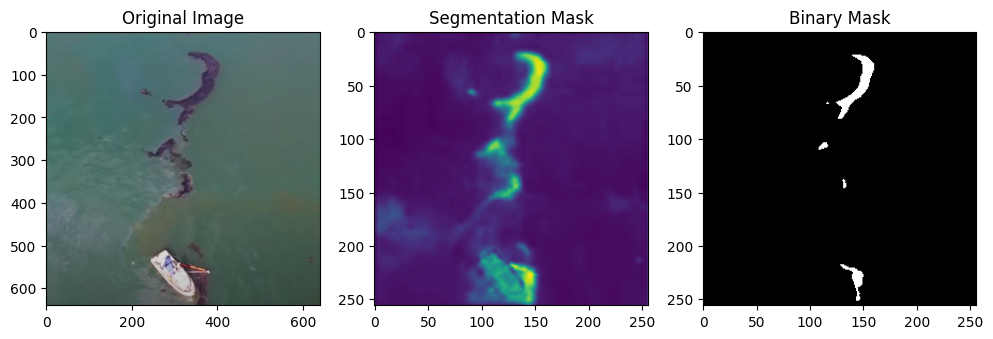

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

# Load the U-Net model
model = keras.models.load_model('unet_model.h5')

# Function to preprocess an image for segmentation
def preprocess_for_segmentation(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Function to perform segmentation using the U-Net model
def segment_image(model, image_path):
    preprocessed_image = preprocess_for_segmentation(image_path)
    segmentation_mask = model.predict(preprocessed_image)[0, :, :, 0]
    return segmentation_mask

# Example image path
example_image_path = '/content/dataset/test/1004_jpg.rf.977057c9c9aeed26de5d5006a922df30.jpg'

# Perform segmentation
segmentation_result = segment_image(model, example_image_path)

# Threshold the segmentation mask (you can adjust the threshold)
threshold = 0.3
binary_mask = (segmentation_result > threshold).astype(np.uint8)

# Display the original image, segmentation mask, and binary mask
original_image = cv2.imread(example_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(segmentation_result, cmap='viridis')
plt.title('Segmentation Mask')

plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')

plt.show()
